In [1]:
from src.helper import get_split_data
import pandas as pd

In [39]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(3)

X = pd.concat([X_trn, X_val], axis='index')
y = pd.Series([*y_trn, *y_val], index=X.index)

KeyboardInterrupt: 

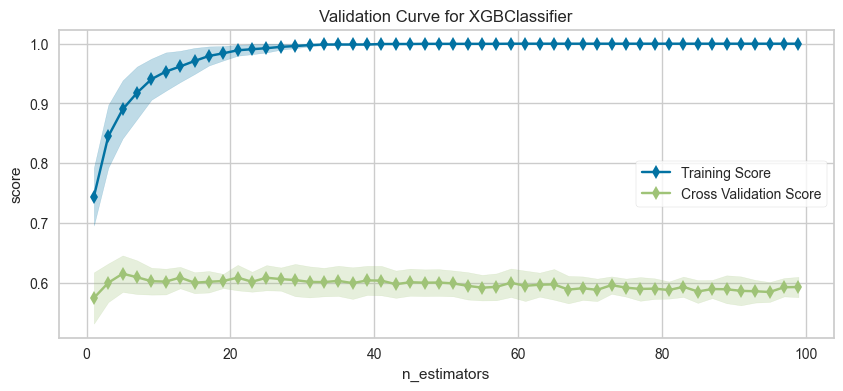

In [3]:
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from yellowbrick.model_selection import validation_curve
import xgboost as xgb

tscv = TimeSeriesSplit(n_splits=3)

fig, ax = plt.subplots(figsize=(10, 4))
viz = validation_curve(xgb.XGBClassifier(random_state=42), X=X, y=y, param_name='n_estimators',
                       param_range=range(1, 100, 2), scoring='f1_weighted', cv=tscv, ax=ax)

In [4]:
from sklearn.metrics import f1_score

xg = xgb.XGBClassifier(random_state=42, n_estimators=74)
xg.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)
y_pred = xg.predict(X_tst)

f1_score(y_tst, y_pred).round(3)

np.float64(0.769)

In [5]:
xg.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 74,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

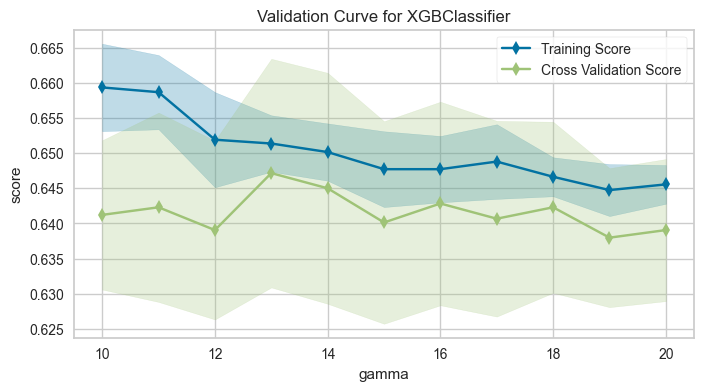

ValidationCurve(ax=<Axes: title={'center': 'Validation Curve for XGBClassifier'}, xlabel='gamma', ylabel='score'>,
                estimator=XGBClassifier(base_score=None, booster=None,
                                        callbacks=None, colsample_bylevel=None,
                                        colsample_bynode=None,
                                        colsample_bytree=None, device=None,
                                        early_stopping_rounds=None,
                                        enable_categorical=False,
                                        eval_metric=None, feature_types=None,
                                        gamma=No...
                                        learning_rate=None, max_bin=None,
                                        max_cat_threshold=None,
                                        max_cat_to_onehot=None,
                                        max_delta_step=None, max_depth=None,
                                        max_leaves=None, min_child_weight=None,
                                        missing=nan, monotone_constraints=None,
                                        multi_strategy=None, n_estimators=None,
                                        n_jobs=None, num_parallel_tree=None,
                                        random_state=None, ...),
                n_jobs=-1, param_name='gamma',
                param_range=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]))

In [6]:
import yellowbrick.model_selection as ms

fig, ax = plt.subplots(figsize=(8, 4))
ms.validation_curve(xgb.XGBClassifier(), X_trn, y_trn, param_name='gamma', param_range=np.arange(10, 21), n_jobs=-1,
                    ax=ax)
# 13

In [10]:
class_names_str = ['home_win' if cls == 1 else 'home_not_win' for cls in y_trn]
features = list(c for c in X_trn.columns)

<Axes: >

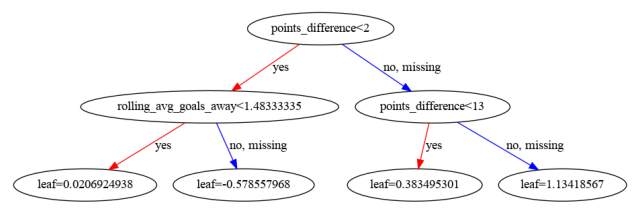

In [13]:
xg_lr1 = xgb.XGBClassifier(learning_rate=1, max_depth=2)
xg_lr1.fit(X_trn, y_trn)

fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_tree(xg_lr1, ax=ax)

<Axes: >

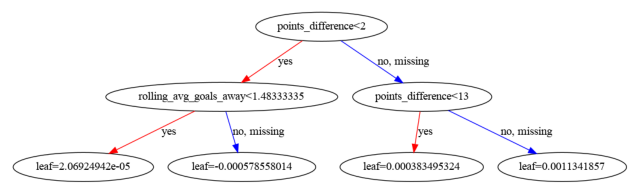

In [14]:
xg_lr001 = xgb.XGBClassifier(learning_rate=0.001, max_depth=2)
xg_lr001.fit(X_trn, y_trn)

fig, ax = plt.subplots(figsize=(8, 4))
xgb.plot_tree(xg_lr001, ax=ax)

In [32]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, f1_score
from typing import Any, Dict, Union


def hyperparameter_tuning(space: Dict[str, Union[float, int]],
                          X_train: pd.DataFrame, y_train: pd.Series,
                          X_val: pd.DataFrame, y_val: pd.Series,
                          X_test: pd.DataFrame, y_test: pd.Series,
                          early_stopping_rounds: int = 50,
                          metric: callable = accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """

    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val)
             for k, val in space.items()}
    # space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                  (X_val, y_val)]
    model.fit(X_train, y_train,
              # eval_set=evaluation,
              verbose=False)
    pred = model.predict(X_val)
    score = metric(y_val, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

In [33]:
options = {'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
           'subsample': hp.uniform('subsample', 0.5, 1),  # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 10),
           'reg_lambda': hp.uniform('reg_lambda', 1, 10),
           'gamma': hp.loguniform('gamma', -10, 10),  # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0),  # boosting
           'random_state': 42
           }

In [34]:
trials = Trials()
best = fmin(
    fn=lambda space: hyperparameter_tuning(
        space,
        X_train=X_trn, y_train=y_trn,
        X_val=X_val, y_val=y_val,
        X_test=X_tst, y_test=y_tst,
    ),
    space=options,
    algo=tpe.suggest,
    max_evals=2_000,
    trials=trials
)

100%|██████████| 2000/2000 [03:41<00:00,  9.01trial/s, best loss: -0.9]


In [35]:
import trail_helper

trial_df = trail_helper.trial2df(trials)

In [36]:
(trial_df
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
 )

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,loss,tid
colsample_bytree,1.000000,-0.017870,-0.036248,0.124230,0.098060,0.325306,0.011992,0.165576,-0.153021,-0.091690
gamma,-0.017870,1.000000,-0.009553,-0.167716,-0.064477,-0.117391,-0.015995,-0.186376,0.047986,-0.325514
learning_rate,-0.036248,-0.009553,1.000000,0.065928,-0.339137,-0.155149,0.047530,-0.135122,0.456904,0.365854
max_depth,0.124230,-0.167716,0.065928,1.000000,-0.016285,0.390959,0.183857,0.274272,-0.133129,0.300895
min_child_weight,0.098060,-0.064477,-0.339137,-0.016285,1.000000,0.229750,-0.071977,0.219523,-0.191812,-0.265472
reg_alpha,0.325306,-0.117391,-0.155149,0.390959,0.229750,1.000000,0.147628,0.376017,-0.218104,-0.044380
reg_lambda,0.011992,-0.015995,0.047530,0.183857,-0.071977,0.147628,1.000000,-0.057803,-0.008709,0.071272
subsample,0.165576,-0.186376,-0.135122,0.274272,0.219523,0.376017,-0.057803,1.000000,-0.272308,0.111500
loss,-0.153021,0.047986,0.456904,-0.133129,-0.191812,-0.218104,-0.008709,-0.272308,1.000000,0.167268
tid,-0.091690,-0.325514,0.365854,0.300895,-0.265472,-0.044380,0.071272,0.111500,0.167268,1.000000


In [37]:
trial_df

,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,reg_alpha,reg_lambda,subsample,loss,tid
0,0.526386,0.001197,0.001825,2.0,0.251360,8.079700,2.495912,0.854294,-0.6,0
1,0.977867,3.348786,0.247688,5.0,0.186935,3.000703,2.337996,0.820147,-0.7,1
2,0.776671,0.000101,0.024684,6.0,5.675714,9.085749,4.772942,0.724904,-0.6,2
3,0.682339,2.400348,0.004915,3.0,2.846881,2.364504,7.763603,0.519009,-0.7,3
4,0.791420,1715.847506,0.387501,5.0,0.181456,6.223344,7.131639,0.764728,-0.6,4
...,...,...,...,...,...,...,...,...,...,...
1995,0.637733,0.137598,0.166974,6.0,0.143653,1.678375,3.502346,0.590467,-0.4,1995
1996,0.907214,0.007025,0.091190,7.0,0.766649,6.136421,4.421283,0.581174,-0.7,1996
1997,0.674018,0.000464,0.577768,5.0,0.187231,1.251365,4.747249,0.608477,-0.5,1997
1998,0.661752,0.000311,0.492605,5.0,0.161029,1.124389,4.303714,0.597273,-0.5,1998


In [38]:
trial_df.iloc[1770].to_dict()

{'colsample_bytree': 0.7127288644719173,
 'gamma': 0.00021228661010984107,
 'learning_rate': 0.3814026050573957,
 'max_depth': 6.0,
 'min_child_weight': 0.37200922349579324,
 'reg_alpha': 2.22246904687468,
 'reg_lambda': 9.385831414023908,
 'subsample': 0.637216207495826,
 'loss': -0.9,
 'tid': 1770.0}